Import libraries, check GPU availability, and define constants.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

_ = torch.manual_seed(42)

Define the training and test transformations for data augmentation.

In [2]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

Load the MNIST dataset and split it into training, validation, and test sets.

In [3]:
train_data = MNIST(root="data", train=True, transform=train_transform, download=True)

train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

test_data = MNIST(root="data", train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Define a convolutional neural network with three convolutional layers, pooling, dropout, and two fully connected layers for classification.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net().to(device)

Define the optimizer, loss function, and functions to train and evaluate the model for one epoch.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(loader):
    model.train()
    total_train_loss = 0.0
    correct = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_loss = total_train_loss / len(loader.dataset)
    accuracy = 100 * correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(loader, return_preds=False):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = 100 * correct / len(loader.dataset)
    
    if return_preds:
        return avg_loss, accuracy, all_preds, all_labels
    return avg_loss, accuracy

Train the model for the specified number of epochs, record training and validation losses and accuracies for plotting, and evaluate the final model on the test set.

In [6]:
def run_training():
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(train_loader)
        val_loss, val_acc = evaluate(val_loader)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return train_losses, train_accs, val_losses, val_accs

train_losses, train_accs, val_losses, val_accs = run_training()
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader, return_preds=True)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Epoch [1/10] Train Loss: 0.3713 | Train Acc: 88.12% | Val Loss: 0.1149 | Val Acc: 96.67%


Epoch [2/10] Train Loss: 0.1350 | Train Acc: 95.90% | Val Loss: 0.0771 | Val Acc: 97.58%


Epoch [3/10] Train Loss: 0.1086 | Train Acc: 96.74% | Val Loss: 0.0606 | Val Acc: 98.20%


Epoch [4/10] Train Loss: 0.0844 | Train Acc: 97.50% | Val Loss: 0.0546 | Val Acc: 98.38%


Epoch [5/10] Train Loss: 0.0765 | Train Acc: 97.71% | Val Loss: 0.0494 | Val Acc: 98.38%


Epoch [6/10] Train Loss: 0.0737 | Train Acc: 97.78% | Val Loss: 0.0485 | Val Acc: 98.41%


Epoch [7/10] Train Loss: 0.0660 | Train Acc: 97.97% | Val Loss: 0.0416 | Val Acc: 98.77%


Epoch [8/10] Train Loss: 0.0584 | Train Acc: 98.20% | Val Loss: 0.0422 | Val Acc: 98.67%


Epoch [9/10] Train Loss: 0.0607 | Train Acc: 98.16% | Val Loss: 0.0515 | Val Acc: 98.40%


Epoch [10/10] Train Loss: 0.0555 | Train Acc: 98.36% | Val Loss: 0.0395 | Val Acc: 98.90%


Test Loss: 0.0163 | Test Accuracy: 99.55%


Plot training and validation losses and accuracies over epochs.

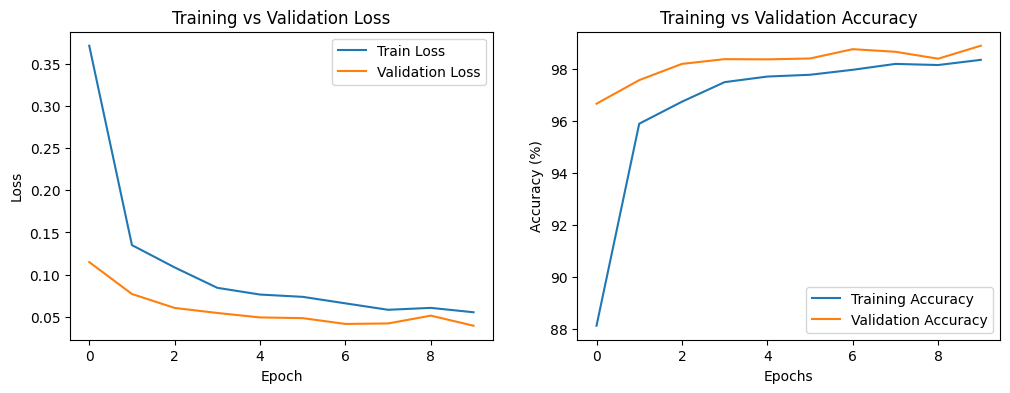

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(train_losses, label="Train Loss")
ax1.plot(val_losses, label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()

ax2.plot(train_accs, label="Training Accuracy")
ax2.plot(val_accs, label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()

plt.show()

Create a confusion matrix for the test set.

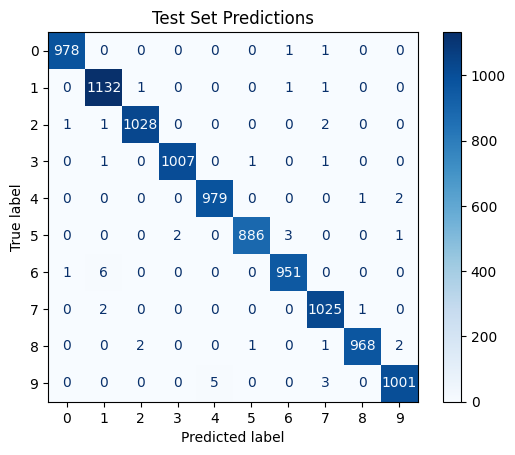

In [8]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
disp.plot(cmap="Blues")
plt.title("Test Set Predictions")
plt.show()